In [1]:
import pandas as pd
import numpy as np
import datetime
from cryptocmd import CmcScraper

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('ggplot')

# Colores Bitcoin
# ==============================================================================
palette_btc = {'naranja': '#f7931a',
               'blanco' : '#ffffff',
               'gris'   : '#4d4d4d',
               'azul'   : '#0d579b',
               'verde'  : '#329239'
              }

# Modelado y Forecasting
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

In [15]:
# Se inicializa el Scraper
scraper = CmcScraper('BTC', '01-01-2013', '01-07-2023')

# Transformar datos recogidos en un dataframe
data = scraper.get_dataframe()
data.sort_values(by='Date', ascending=True, inplace=True)

pd.set_option('display.max_columns', None)
display(data)
pd.reset_option('display.max_columns')

,Date,Open,High,Low,Close,Volume,Market Cap
3715,2013-04-28,135.300003,135.979996,132.100006,134.210007,0.000000e+00,1.488567e+09
3714,2013-04-29,134.444000,147.488007,134.000000,144.539993,0.000000e+00,1.603769e+09
3713,2013-04-30,144.000000,146.929993,134.050003,139.000000,0.000000e+00,1.542813e+09
3712,2013-05-01,139.000000,139.889999,107.720001,116.989998,0.000000e+00,1.298955e+09
3711,2013-05-02,116.379997,125.599998,92.281898,105.209999,0.000000e+00,1.168517e+09
...,...,...,...,...,...,...,...
4,2023-06-26,30480.523973,30636.029430,29955.743294,30271.131017,1.649319e+10,5.876504e+11
3,2023-06-27,30274.321188,31006.786577,30236.651294,30688.163854,1.642883e+10,5.957737e+11
2,2023-06-28,30696.561487,30703.279976,29921.822833,30086.246189,1.457150e+10,5.841087e+11
1,2023-06-29,30086.186717,30796.250240,30057.203020,30445.351226,1.318086e+10,5.911079e+11


In [16]:
# Preparación del dato
# ==============================================================================
data['date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')
data = data.loc[:, ['date', 'Open', 'Close', 'High', 'Low']]
data = data.rename({'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, 
                    axis=1)
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()

In [17]:
#Verifica que no haya nulos
print(f'Número de filas con missing values: {data.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [18]:
btc_halving = {'halving'              : [0, 1 , 2, 3, 4],
               'date'                 : ['2009-01-03', '2012-11-28', 
                                         '2016-07-09', '2022-05-11', np.nan],
               'reward'               : [50, 25, 12.5, 6.25, 3.125],
               'halving_block_number' : [0, 210000, 420000 ,630000, 840000]
              }

In [19]:
# Cálculo siguiente halving
# Se toma como base de partida los bloques restantes según la web 
# coinmarketcap.com para el próximo halving a fecha de 2022-01-14
# ==============================================================================
bloques_restantes = 121400
bloques_por_dia = 144

dias = bloques_restantes / bloques_por_dia

next_halving = pd.to_datetime('2023-01-15', format='%Y-%m-%d') + datetime.timedelta(days=dias)
next_halving = next_halving.replace(microsecond=0, second=0, minute=0, hour=0)
next_halving = next_halving.strftime('%Y-%m-%d')

btc_halving['date'][-1] = next_halving

print(f'El próximo halving ocurrirá aproximadamente el: {next_halving}')

El próximo halving ocurrirá aproximadamente el: 2025-05-07


In [8]:
# Incluir recompensas y cuenta regresiva para próximo halving en el dataset
# ==============================================================================
data['reward'] = np.nan
data['countdown_halving'] = np.nan

for i in range(len(btc_halving['halving'])-1):
     
    # Fecha inicial y final de cada halving
    if btc_halving['date'][i] < data.index.min().strftime('%Y-%m-%d'):
        start_date = data.index.min().strftime('%Y-%m-%d')
    else:
        start_date = btc_halving['date'][i]
        
    end_date = btc_halving['date'][i+1]
    mask = (data.index >= start_date) & (data.index < end_date)
        
    # Rellenar columna 'reward' con las recompensas de minería
    data.loc[mask, 'reward'] = btc_halving['reward'][i]
    
    # Rellenar columna 'countdown_halving' con los días restantes
    time_to_next_halving = pd.to_datetime(end_date) - pd.to_datetime(start_date)
    
    data.loc[mask, 'countdown_halving'] = np.arange(time_to_next_halving.days)[::-1][:mask.sum()]

In [20]:
# Comprobar que se han creado los datos correctamente
# ==============================================================================
print('Segundo halving:', btc_halving['date'][2])
display(data.loc['2016-07-08':'2016-07-09'])
print('')
print('Tercer halving:', btc_halving['date'][3])
display(data.loc['2022-05-10':'2022-05-11'])
print('')
print('Próximo halving:', btc_halving['date'][4])
data.tail(2)

Segundo halving: 2016-07-09


,open,close,high,low
date,,,,
2016-07-08,640.687988,666.523010,666.706970,636.466980
2016-07-09,666.383972,650.960022,666.383972,633.398987



Tercer halving: 2022-05-11


,open,close,high,low
date,,,,
2022-05-10,30273.654219,31022.905412,32596.307836,29944.802737
2022-05-11,31016.182752,28936.355031,32013.401493,28170.413086



Próximo halving: 2025-05-07


,open,close,high,low
date,,,,
2023-06-29,30086.186717,30445.351226,30796.25024,30057.203020
2023-06-30,30441.353759,30477.251282,31256.86270,29600.275939


In [21]:
# Gráfico de velas japonesas interactivo con Plotly
# ==============================================================================
candlestick = go.Candlestick(
                  x     = data.index,
                  open  = data.open,
                  close = data.close,
                  low   = data.low,
                  high  = data.high,
              )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 900,
    height      = 450,
    title       = dict(text='<b>Chart Bitcoin/USD</b>', font=dict(size=30)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=15)),
    margin      = dict(l=10, r=20, t=80, b=20),
    shapes      = [dict(x0=btc_halving['date'][2], x1=btc_halving['date'][2], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][3], x1=btc_halving['date'][3], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][4], x1=btc_halving['date'][4], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2)
                  ],
    annotations = [dict(x=btc_halving['date'][2], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Segundo halving'),
                   dict(x=btc_halving['date'][3], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Tercer halving'),
                   dict(x=btc_halving['date'][4], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Cuarto halving')
                  ],
    xaxis_rangeslider_visible = False,
)

fig.show()

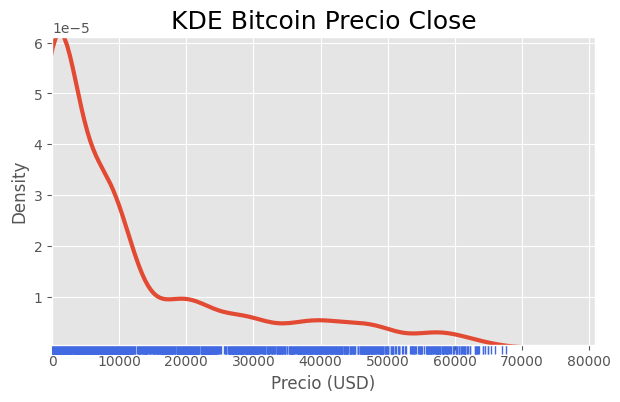

In [22]:
# Distribución KDE del precio de cierre del Bitcoin
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 4))
p = sns.kdeplot(data=data, x='close', linewidth=3, ax=ax)
r = sns.rugplot(data=data, x='close', ax=ax, c='royalblue',
                height=-.03, clip_on=False)
p.set(xlim=(0, None))
p.set_title('KDE Bitcoin Precio Close', fontsize=18)
p.set_xlabel('Precio (USD)');

In [29]:
# Crear columna deltas (% cambio)
# ==============================================================================
# data['change_pct'] = 100*(data['close'] - data['open']) / data['open']
# # Mediante método Pandas pct_change()
# data['change_pct'] = data.pct_change(axis='columns').iloc[:, 1]*100
# 3data.head(2)

IndentationError: unexpected indent (3763863640.py, line 3)

In [30]:
# Se localizan los datos correspondientes para cada año
# ==============================================================================
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    
    year_open  = data.loc[data.index.year == year, 'open'][0]
    year_close = data.loc[data.index.year == year, 'close'][-1]
    year_low   = data.loc[data.index.year == year, 'low'].min()
    year_high  = data.loc[data.index.year == year, 'high'].max()
    
    df_plot[year] = pd.Series([year_open, year_close, year_low, year_high]) 
    
df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

# Se calcula el % de cambio entre el open y el close del año
# ==============================================================================
df_plot['year_change'] = 100*(df_plot['close'] - df_plot['open']) / df_plot['open']
df_plot.head(12)

,open,close,low,high,year_change
2013,135.300003,754.010010,65.526001,1156.140015,457.287504
2014,754.969971,320.192993,289.295990,1017.119995,-57.588645
2015,320.434998,430.566986,171.509995,495.562012,34.369526
2016,430.721008,963.742981,354.914001,979.396973,123.751097
2017,963.658020,14156.400391,755.755981,20089.000000,1369.027404
2018,14112.200195,3742.700335,3191.303562,17712.400391,-73.478974
2019,3746.713387,7193.598978,3391.023752,13796.489081,91.997579
2020,7194.891971,29001.719822,4106.980750,29244.876688,303.087634
2021,28994.008916,46306.446123,28722.755271,68789.625939,59.710395
2022,46311.744663,16547.495366,15599.047175,48086.836749,-64.269333


In [32]:
# Se crea una lista de dicts con las anotaciones de % de cambio para el gráfico
# ==============================================================================
annotations_list = []
max_high = df_plot['high'].max()

for year in years:
    
    df_aux = df_plot.loc[df_plot.index == year,]
    loc_x  = pd.to_datetime(df_aux.index[0], format='%Y')
    loc_y  = df_aux['high'].values[0]/max_high + 0.05
    text   = '{:.1f}%'.format(df_aux['year_change'].values[0])
    
    annotation = dict(x=loc_x, y=loc_y, 
                      xref='x', yref='paper',
                      showarrow=False, xanchor='center', 
                      text=text)

    annotations_list.append(annotation)

# Gráfico de velas japonesas anual interactivo con Plotly
# ==============================================================================
candlestick = go.Candlestick(
                  x     = pd.to_datetime(df_plot.index, format='%Y'),
                  open  = df_plot.open,
                  close = df_plot.close,
                  low   = df_plot.low,
                  high  = df_plot.high
              )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 800,
    height      = 350,
    title       = dict(text='<b>Chart Bitcoin/USD por año</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20),
    xaxis_rangeslider_visible = False,
    annotations = annotations_list
)

fig.show()

In [33]:
# Se localizan los datos correspondientes para cada mes
# ==============================================================================
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    for mes in range(12):
        
        start_date = pd.to_datetime(f'{year}-{mes+1}-01', format='%Y-%m-%d')
        end_date = (start_date + pd.offsets.MonthBegin())
        mask = (data.index >= start_date) & (data.index < end_date)
        
        if not data.loc[mask, :].empty:
                        
            month_open  = data.loc[mask, 'open'][0]
            month_close = data.loc[mask, 'close'][-1]
            month_low   = data.loc[mask, 'low'].min()
            month_high  = data.loc[mask, 'high'].max()
            
            serie  = pd.Series([month_open, month_close, month_low, month_high])
            df_aux = pd.DataFrame(serie, columns=[f'{str(mes+1).zfill(2)}-{year}'])
            
            if df_plot.empty:
                df_plot = df_aux.copy()
            else:
                df_plot = pd.concat([df_plot, df_aux], axis=1)

df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

In [34]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
# df_plot['mes'] = pd.to_datetime(df_plot.index, format='%m-%Y').month
# fig, ax = plt.subplots(figsize=(7, 3.5))
# df_plot.boxplot(column='close', by='mes', ax=ax)
# df_plot.groupby('mes')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Precio (USD)')
# ax.set_title('BTC Precio por mes')
# fig.suptitle('');

df_plot['mes'] = pd.to_datetime(df_plot.index, format='%m-%Y').month

# fig 1 boxplot de los meses
fig1 = px.box(df_plot.sort_values('mes'), x='mes', y='close',
              color_discrete_sequence=[palette_btc['verde']])

# fig 2 line con datos de la mediana de cada mes
df_median = pd.DataFrame(df_plot.groupby('mes')['close'].median()).reset_index()
fig2 = px.line(df_median, x='mes', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gris']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>BTC Precio por mes</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='mes', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

In [35]:
# Gráfico boxplot para estacionalidad mensual
# ==============================================================================
# fig, ax = plt.subplots(figsize=(9, 3.5))
# data['dia_mes'] = pd.Series(data.index).dt.day.values
# data.boxplot(column='close', by='dia_mes', ax=ax)
# data.groupby('dia_mes')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Precio (USD)')
# ax.set_title('BTC Precio por día del mes')
# fig.suptitle('');

data['dia_mes'] = pd.Series(data.index).dt.day.values

# fig 1 boxplot de los días del mes
fig1 = px.box(data.sort_values('dia_mes'), x='dia_mes', y='close',
              color_discrete_sequence=[palette_btc['verde']])

# fig 2 line con datos de la mediana de los días del mes
df_median = pd.DataFrame(data.groupby('dia_mes')['close'].median()).reset_index()
fig2 = px.line(df_median, x='dia_mes', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gris']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 750,
    height      = 350,
    title       = dict(text='<b>BTC Precio por día del mes</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear', tickangle=0, range=[0.5, 31.5]),
    xaxis_title = dict(text='día', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

In [36]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
# fig, ax = plt.subplots(figsize=(7, 3.5))
# data['dia_semana'] = data.index.day_of_week + 1
# data.boxplot(column='close', by='dia_semana', ax=ax)
# data.groupby('dia_semana')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Precio (USD)')
# ax.set_title('BTC Precio por día de la semana');

data['dia_semana'] = data.index.day_of_week + 1

# fig 1 boxplot de los días de la semana
fig1 = px.box(data.sort_values('dia_semana'), x='dia_semana', y='close',
              color_discrete_sequence=[palette_btc['verde']])

# fig 2 line con datos de la mediana los días de la semana
df_median = pd.DataFrame(data.groupby('dia_semana')['close'].median()).reset_index()
fig2 = px.line(df_median, x='dia_semana', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gris']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>BTC Precio por día de la semana</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='día de la semana', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

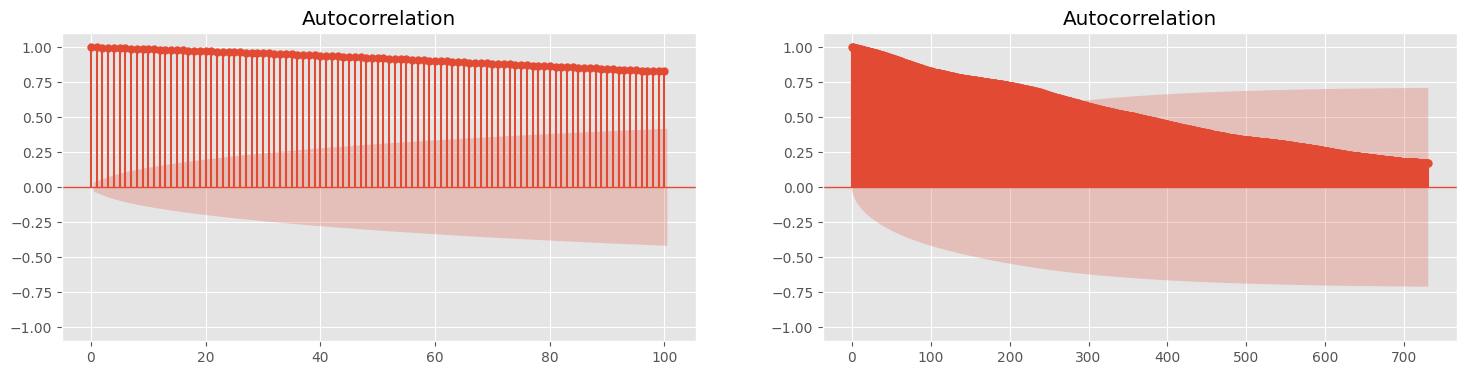

In [37]:
# Gráfico autocorrelación
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(data.close, ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(data.close, ax=axes[1], linewidth = 1, lags=730)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

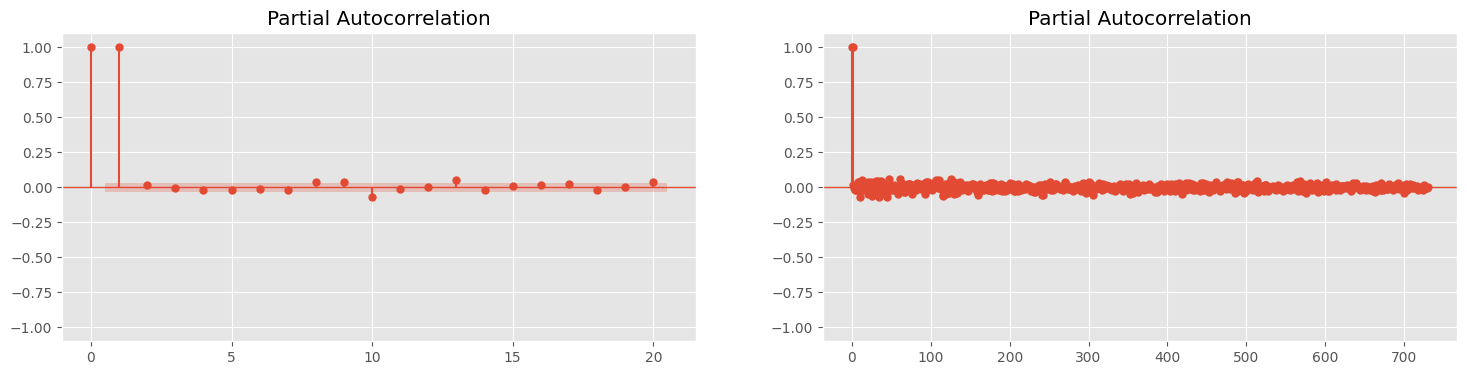

In [38]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_pacf(data.close, ax=axes[0], lags=20, method='ywm',  linewidth = 1)
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(data.close, ax=axes[1], lags=730, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

In [39]:
# Selección fechas train-test
# ==============================================================================
inicio_train = '2020-01-01 00:00:00'
fin_train = '2021-06-30 23:59:59'

print(f"Serie temporal completa : {data.index.min()} --- {data.index.max()}  (n={len(data)})")
print(f"Fechas train            : {data.loc[inicio_train:fin_train].index.min()} --- {data.loc[inicio_train:fin_train].index.max()}  (n={len(data.loc[inicio_train:fin_train])})")
print(f"Fechas test             : {data.loc[fin_train:].index.min()} --- {data.loc[fin_train:].index.max()}  (n={len(data.loc[fin_train:])})")

Serie temporal completa : 2013-04-28 00:00:00 --- 2023-06-30 00:00:00  (n=3716)
Fechas train            : 2020-01-01 00:00:00 --- 2021-06-30 00:00:00  (n=547)
Fechas test             : 2021-07-01 00:00:00 --- 2023-06-30 00:00:00  (n=730)


In [40]:
# Simulación Random Walk
# ==============================================================================
df_rw = data[['close']].copy()
df_rw['pred_close'] = df_rw['close'].shift(1)

# Error de test
# ==============================================================================
y_true = df_rw.loc[fin_train:, 'close']
y_pred = df_rw.loc[fin_train:, 'pred_close']
metrica = mean_absolute_error(y_true, y_pred)

print(f'Error de test: {metrica}')
display(df_rw.loc[fin_train:,].head(4))

Error de test: 757.840130455146


,close,pred_close
date,,
2021-07-01,33572.117653,35040.837249
2021-07-02,33897.048590,33572.117653
2021-07-03,34668.548402,33897.048590
2021-07-04,35287.779766,34668.548402


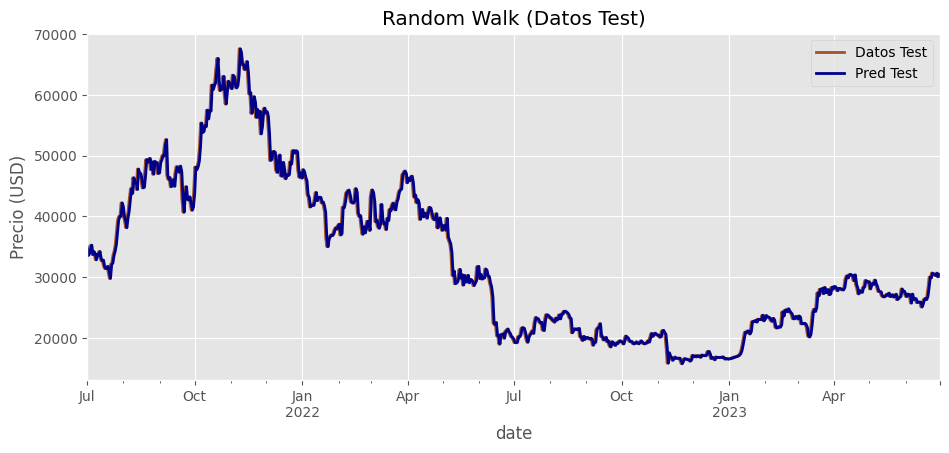

In [41]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
df_rw.loc[fin_train:, 'close'].plot(ax=ax, linewidth=2, label='Datos Test',
                                    c='sienna')
df_rw.loc[fin_train:, 'pred_close'].plot(ax=ax, linewidth=2, label='Pred Test',
                                    c='darkblue')
ax.set_title('Random Walk (Datos Test)')
ax.set_ylabel('Precio (USD)')
ax.legend();

In [42]:
# DataFrame errores test modelos
# ==============================================================================
df_errores = pd.DataFrame({'modelo': 'Base - Random Walk', 'lags': 1, 
                           'error_test': metrica, 'variables_exog': False},
                          index=[0])
df_errores

,modelo,lags,error_test,variables_exog
0,Base - Random Walk,1,757.84013,False


In [43]:
# Backtest forecasters con diferentes lags
# ==============================================================================
lags = [1, 7, 30]
metricas = []
predicciones_list = []

for lag in lags:
    
    # Crear forecaster
    forecaster = ForecasterAutoreg(
                     regressor     = LGBMRegressor(random_state=123),
                     lags          = lag,
                     transformer_y = None
                 )
    
    # Backtest test data 1 step
    metrica, predicciones = backtesting_forecaster(
                                forecaster         = forecaster,
                                y                  = data.loc[inicio_train:, 'close'],
                                initial_train_size = len(data.loc[inicio_train:fin_train, 'close']),
                                fixed_train_size   = True,
                                steps              = 1,
                                refit              = True,
                                metric             = 'mean_absolute_error',
                                verbose            = False
                            )
    
    metricas.append(metrica)
    predicciones_list.append(predicciones)

C:\Python311\Lib\site-packages\skforecast\model_selection\model_selection.py:448: LongTrainingWarning:

The forecaster will be fit 730 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)



  0%|          | 0/730 [00:00<?, ?it/s]

C:\Python311\Lib\site-packages\skforecast\model_selection\model_selection.py:448: LongTrainingWarning:

The forecaster will be fit 730 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)



  0%|          | 0/730 [00:00<?, ?it/s]

C:\Python311\Lib\site-packages\skforecast\model_selection\model_selection.py:448: LongTrainingWarning:

The forecaster will be fit 730 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)



  0%|          | 0/730 [00:00<?, ?it/s]